In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import torch
from collections import defaultdict
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd


In [ ]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [ ]:
from PIL import Image
# root_dir = '../input/output-crns/CRNS_OUTPUT'
class HeightandWidth(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)  # Chargement des données à partir d'un fichier CSV
        self.root_dir = root_dir  # Répertoire racine contenant les images
        self.transform = transform  # Transformation à appliquer aux images

    def __len__(self):
        return len(self.data)  # Retourne la taille du dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Chemin d'accès à l'image
        print(img_name)
        image = cv2.imread(img_name)  # Lecture de l'image à l'aide de OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversion de l'espace de couleur de BGR à RGB

        label = self.data.iloc[idx, 1]  # Extraction de l'étiquette associée à l'image

        if self.transform:
            pic = self.transform(image)  # Application de la transformation spécifiée aux images

        return pic, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir l'image en objet de type PIL (Pillow)
    transforms.Resize((900, 700)),
    transforms.RandomRotation(10),  # Effectuer une rotation aléatoire de l'image dans la plage de -10 à +10 degrés
    transforms.ToTensor()  # Convertir l'image en tenseur PyTorch
])
#transforms.Resize((900, 700)),  # Redimensionner l'image à une taille spécifiée

In [ ]:
#

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    real_values = []  # To store real values
    predicted_values = []
    for inputs, labels in train_loader:
        #print("\n labels",labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels.unsqueeze_(dim=1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #print("label float(train)",labels.float(),"outputs",outputs)
        loss = loss_fn(outputs, labels.float())
        real_values.extend(labels.float().tolist())
        predicted_values.extend(outputs.tolist())
        losses.append(loss.item())
       # Calcul des gradients, mise à jour des poids et réinitialisation des gradients à zéro
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    threshold = 0.25
    matches = (np.array(predicted_values) >= (np.array(real_values) - threshold)) & (np.array(predicted_values) <= (np.array(real_values) + threshold))
    matches_tensor = torch.from_numpy(matches.astype(int))
    correct_predictions += torch.sum(matches_tensor)
        # Calcul des gradients, mise à jour des poids et réinitialisation des gradients à zéro

    plt.scatter(real_values, predicted_values)
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Real Values vs Predicted Values(train)')
    plt.show()
    # Mise à jour du scheduler
    scheduler.step()

    # Calcul de la précision et de la perte moyenne
    return float(correct_predictions) / len(predicted_values), np.mean(losses)


In [ ]:
def eval_model(model, validation_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    real_values = []  # To store real values
    predicted_values = []

    for inputs, labels in validation_loader:

        inputs = inputs.to(device)
        #print("inputs :",inputs)
        labels = labels.to(device)
        labels.unsqueeze_(dim=1)
        outputs = model(inputs)

        #print('label_float(eval)',labels.float(),'  outputs  ',outputs)
        # Calcul des prédictions et de la perte
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels.float())
        real_values.extend(labels.float().tolist())
        predicted_values.extend(outputs.tolist())
        losses.append(loss.item())
        # Mise à jour des prédictions correctes et des pertes
    threshold = 0.25
    matches = (np.array(predicted_values) >= (np.array(real_values) - threshold)) & (np.array(predicted_values) <= (np.array(real_values) + threshold))
    matches_tensor = torch.from_numpy(matches.astype(int))
    correct_predictions += torch.sum(matches_tensor)
    plt.scatter(real_values, predicted_values)

    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Real Values vs Predicted Values(val)')
    plt.show()
    # Calcul de la précision et de la perte moyenne
    return float(correct_predictions) / len(predicted_values), np.mean(losses)


In [ ]:
def train_model(model, device, n_epochs=60):
    dataset = HeightandWidth(csv_file='/content/drive/MyDrive/olive/Tree_height.csv',
                          root_dir='/content/drive/MyDrive/olive/segmented/',
                          transform=transform)

    batch_size = 8
    validation_split = 0.2
    shuffle_dataset = True
    random_seed = 42

    # Obtention de la taille du jeu de données
    dataset_size = len(dataset)
    print("\n dataset_size",dataset_size)
    # Création de la liste des indices des échantillons
    indices = list(range(dataset_size))
    print("\n indices",indices)
    # Calcul de l'indice de séparation entre les ensembles d'entraînement et de validation
    split = int(np.floor(validation_split * dataset_size))
    print("\n split",split)

    # Mélange aléatoire des indices si shuffle_dataset est True
    if shuffle_dataset:
      np.random.seed(random_seed)
      np.random.shuffle(indices)

    # Division des indices en ensembles d'entraînement et de validation
    train_indices, val_indices = indices[split:], indices[:split]
    print("\n train_indices",train_indices)
    print("\n val_indices",val_indices)

    # Création des échantillonneurs pour les ensembles d'entraînement et de validation
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    print("\n train_sampler",train_sampler)
    print("\n valid_sampler",valid_sampler)

    # Création des chargeurs de données pour l'entraînement et la validation
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    # Set requires_grad=False for all parameters initially
    save_dir = '/content/drive/MyDrive/olive/'
    #weight_decay = 0.001
    weight_decay=0
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6,weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.MSELoss()
    history = defaultdict(list)
    best_accuracy = 0
    best_train_loss=0
    best_test_loss=0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        #print("train loader" ,len(train_loader))

        # Entraînement du modèle
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(train_loader))
        print(f'Train loss {train_loss}')
        print(f'train acc {train_acc}')
        # Évaluation du modèle sur les données de validation
        val_acc, val_loss = eval_model(model, validation_loader, loss_fn, device, len(validation_loader))
        print(f'Val loss {val_loss}')
        print(f'val acc {val_acc}')
        #print()
        torch.save(model.state_dict(), save_dir + 'resnet34_21_07_checkpointx.pth')
        # Enregistrement des métriques d'entraînement et de validation dans l'historique
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Sauvegarde du meilleur modèle basé sur la précision de validation
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            best_train_loss=train_loss
            best_test_loss = val_loss
    epochs = range(1, len(history['train_loss']) + 1)

    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(epochs, history['train_acc'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation Accuracy')
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print( "best_accuracy: ", best_accuracy)
    print("best_train_loss: ",best_train_loss)
    print("best_test_loss: ",best_test_loss)


    return model, history


In [ ]:
model34 = models.resnet34(pretrained=True)
print(model34.fc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)


In [ ]:
num_features = model34.fc.in_features

print("Number of features:", num_features)

Number of features: 512


In [ ]:

for param in model34.parameters():
    # entrainer que final layer
    param.required_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model34.to(device)
#dropout_prob = 0.1  # Set the dropout probability
dropout_prob=0
model34.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),  # Add dropout layer here
    nn.Linear(128, 1)
).to(device)


In [ ]:
from torchsummary import summary
# Print the summary of the model
summary(model34,input_size=(3,900, 700))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 450, 350]           9,408
       BatchNorm2d-2         [-1, 64, 450, 350]             128
              ReLU-3         [-1, 64, 450, 350]               0
         MaxPool2d-4         [-1, 64, 225, 175]               0
            Conv2d-5         [-1, 64, 225, 175]          36,864
       BatchNorm2d-6         [-1, 64, 225, 175]             128
              ReLU-7         [-1, 64, 225, 175]               0
            Conv2d-8         [-1, 64, 225, 175]          36,864
       BatchNorm2d-9         [-1, 64, 225, 175]             128
             ReLU-10         [-1, 64, 225, 175]               0
       BasicBlock-11         [-1, 64, 225, 175]               0
           Conv2d-12         [-1, 64, 225, 175]          36,864
      BatchNorm2d-13         [-1, 64, 225, 175]             128
             ReLU-14         [-1, 64, 2


 dataset_size 400

 indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

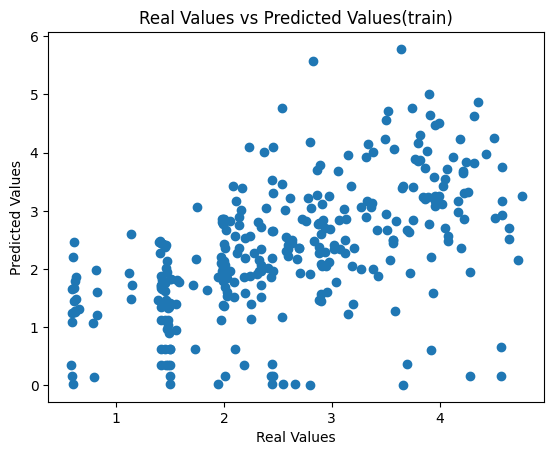

Train loss 1.1609687795862556
train acc 0.20625
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_1

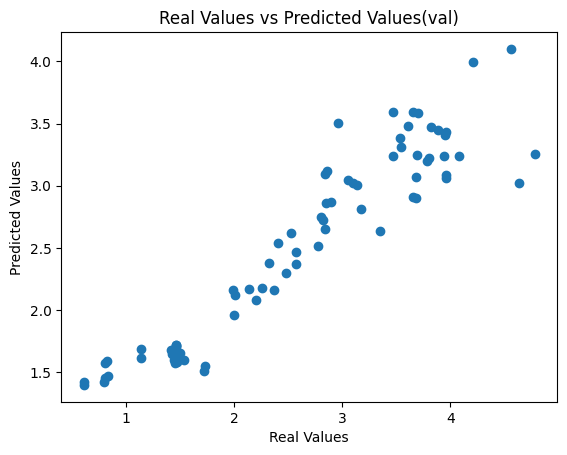

Val loss 0.22172894980758429
val acc 0.55
Epoch 2/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im10_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_3.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003.jpg
/content/drive/MyDrive/olive/segmented/md1_3.jpg
/content/drive/MyDrive/olive/segmented/O_131625_3.jpg
/content/drive/MyDrive/olive/segmented/im

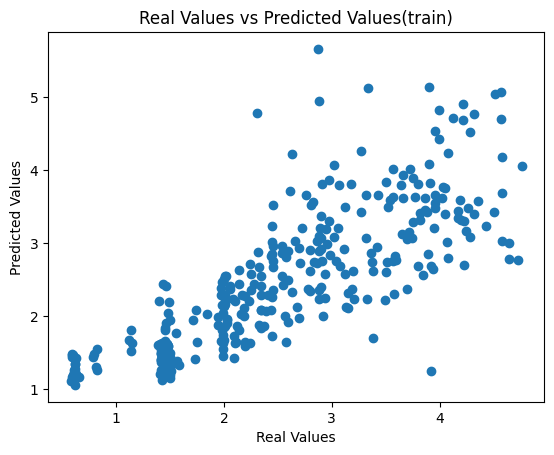

Train loss 0.43291491698473694
train acc 0.35
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/dri

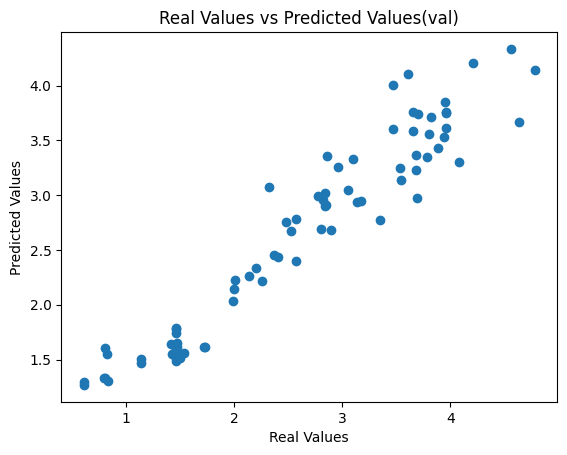

Val loss 0.12343860194087028
val acc 0.6125
Epoch 3/60
----------
/content/drive/MyDrive/olive/segmented/im14_3.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146.jpg
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/O_124141_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_1.jpg
/content/drive/MyDrive/olive/segmented/md3_2.jpg

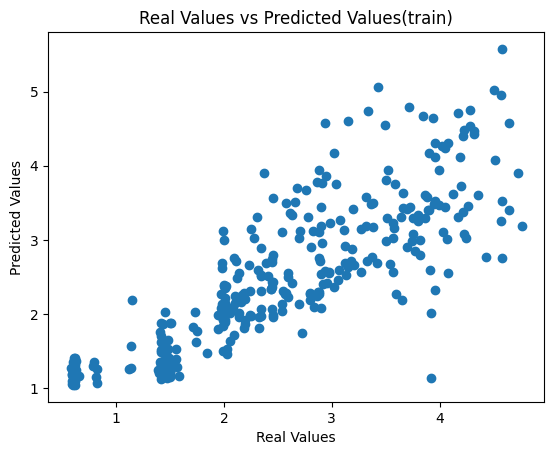

Train loss 0.37161732437089084
train acc 0.334375
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.j

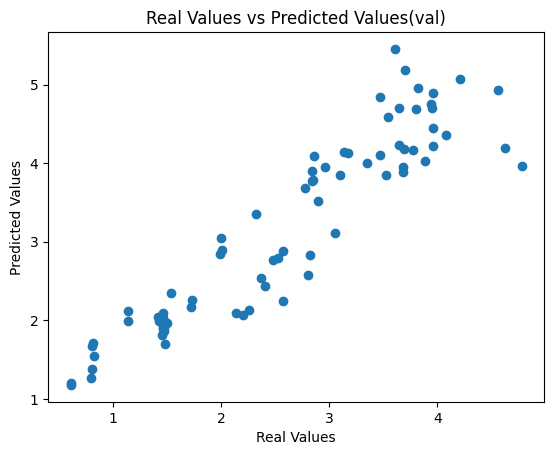

Val loss 0.5123477637767792
val acc 0.1375
Epoch 4/60
----------
/content/drive/MyDrive/olive/segmented/md2_10.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/md2_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/md3_4.jpg
/content/drive/MyDrive/olive/segmented/im1_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_4.jpg
/content/drive/MyDrive/olive/segmented/im7_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_3.jpg
/content/drive/MyDrive/olive/segmented/O_131625_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_3.jpg
/content/drive/MyDrive/olive/segmented/im6.jpg
/content/drive/MyDrive/olive/segmented/im7_4.jpg
/content/drive/MyDriv

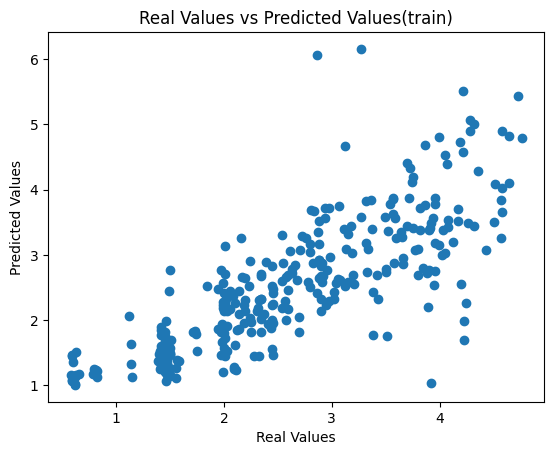

Train loss 0.43414627355523405
train acc 0.353125
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segment

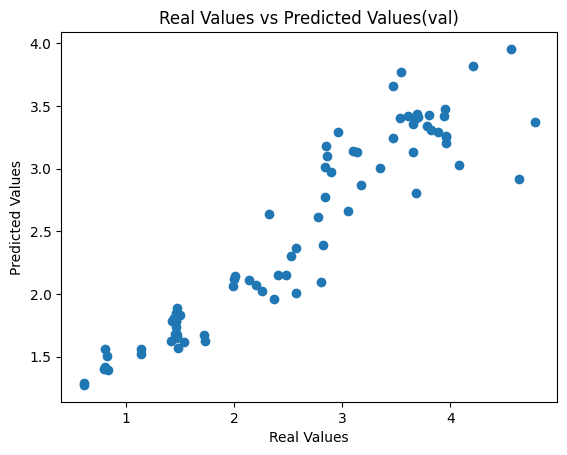

Val loss 0.22578234374523162
val acc 0.3875
Epoch 5/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427.jpg
/content/drive/MyDrive/olive/segmented/md4_5_6.jpg
/content/drive/MyDrive/olive/segmented/md2_2_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/im1_5.jpg
/content/drive/MyDrive/olive/segmented/im8_4.jpg
/content/drive/MyDrive/olive/segmented/im6.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_2.jpg
/content/drive/MyDrive/olive/segmented/im14.jpg
/content/dr

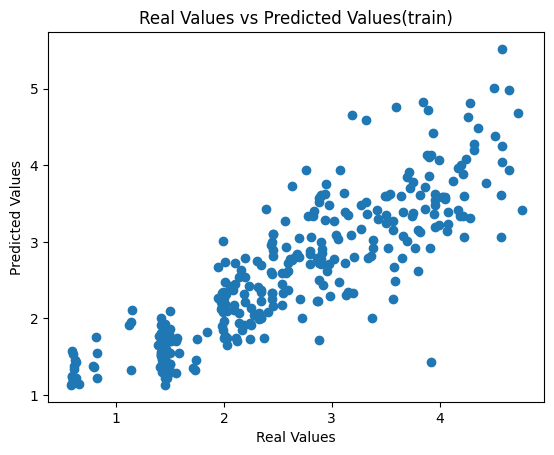

Train loss 0.275716816354543
train acc 0.3875
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive

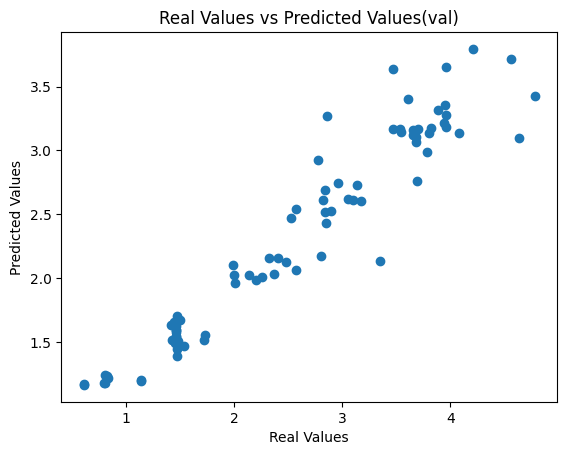

Val loss 0.23319703489542007
val acc 0.4625
Epoch 6/60
----------
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/md7_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/O_130123_3.jpg
/content/drive/MyDrive/olive/segmented/O_131625_1.jpg
/content/drive/MyDrive/olive/segmented/md1_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_122127.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_081229

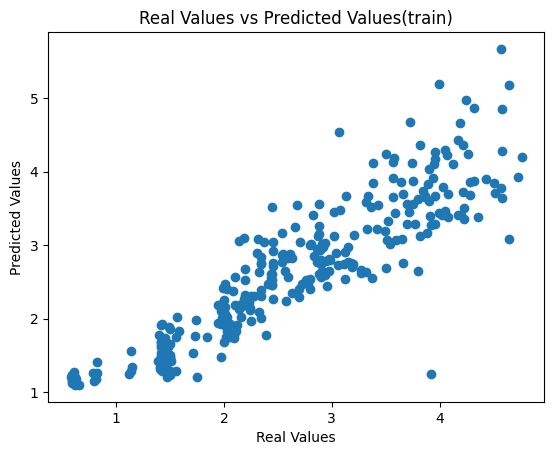

Train loss 0.20060436916537583
train acc 0.459375
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im14_5.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im2.jpg
/content/drive/MyDrive/olive/segmented/md7_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content

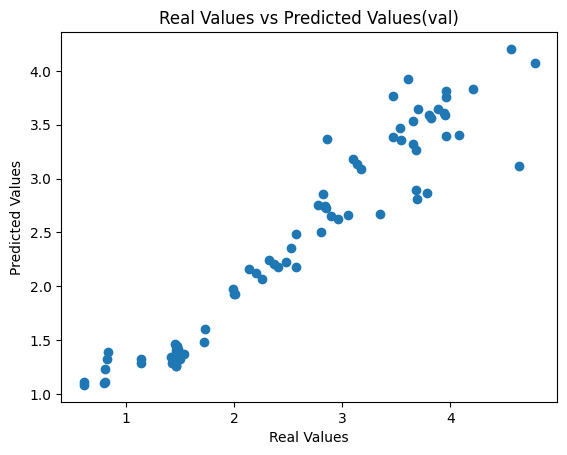

Val loss 0.13024663552641869
val acc 0.625
Epoch 7/60
----------
/content/drive/MyDrive/olive/segmented/md4_5_translation_7.jpg
/content/drive/MyDrive/olive/segmented/O_124141_1.jpg
/content/drive/MyDrive/olive/segmented/md2_1_6.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/im8_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_8.jpg
/content/drive/MyDrive/olive/segmented/md3_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_5.jpg
/content/drive/MyDrive/olive/segmented/im7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_2.jpg
/content/drive/MyD

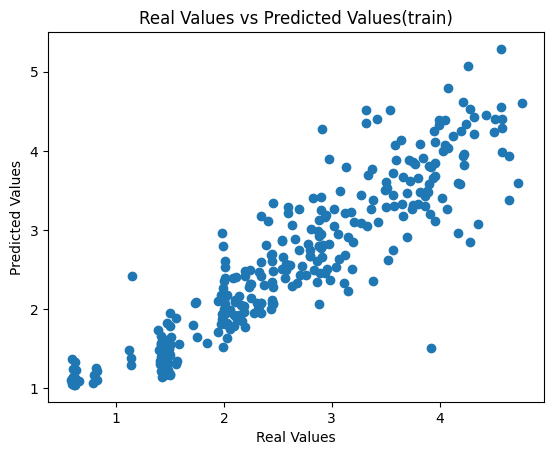

Train loss 0.1909809206612408
train acc 0.4875
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083056_4.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDr

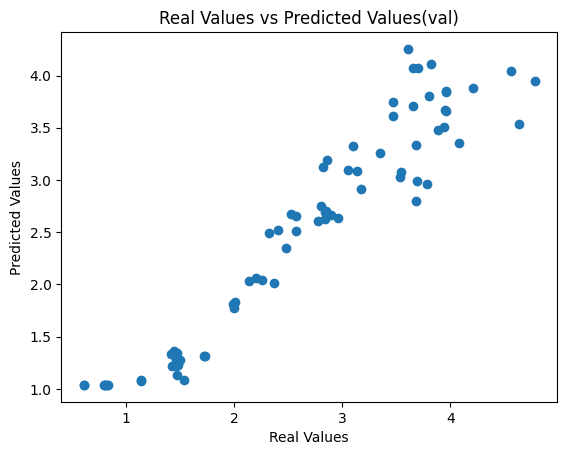

Val loss 0.1201351560652256
val acc 0.6
Epoch 8/60
----------
/content/drive/MyDrive/olive/segmented/im1_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_1.jpg
/content/drive/MyDrive/olive/segmented/md3_3_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_3.jpg
/content/drive/MyDrive/olive/segmented/im12_5.jpg
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_1.jpg
/content/drive/MyDrive/olive/segmented/md3.jpg
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/md3_1.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md2_1.jpg
/content/drive/MyDrive/olive/segmented/O_124141_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103

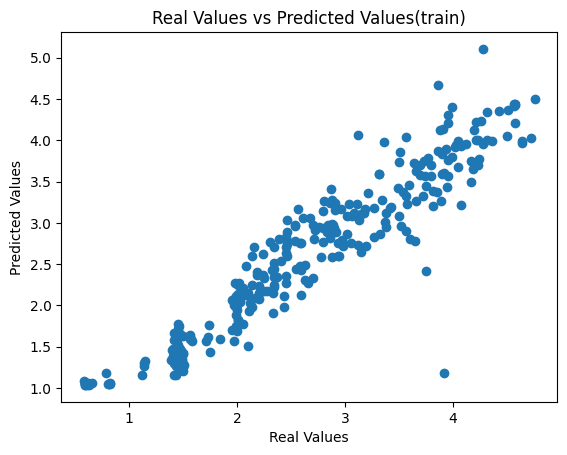

Train loss 0.11796190591994674
train acc 0.609375
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/im6_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10.jpg
/content/driv

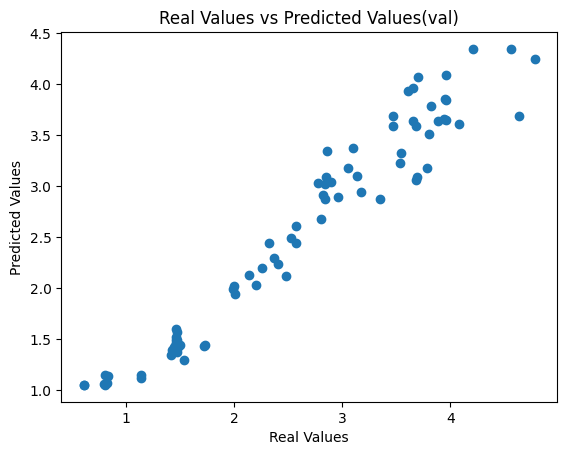

Val loss 0.07020896021276712
val acc 0.675
Epoch 9/60
----------
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/drive/MyDrive/olive/segmented/md3_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080733_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_1_7.jpg
/content/drive/MyDrive/olive/segmented/O_125721_4.jpg
/content/drive/MyDrive/olive/segmented/md1_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_111447_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044.jpg
/content/drive/MyDrive/olive/segmented/O_125721_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_

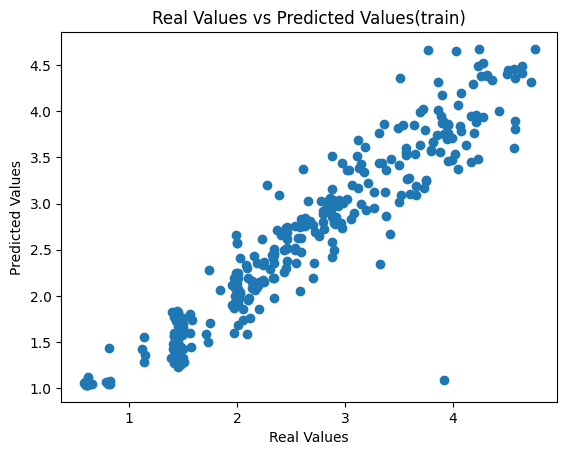

Train loss 0.11936874197563156
train acc 0.63125
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md8_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_100624_5.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/im3_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/IM

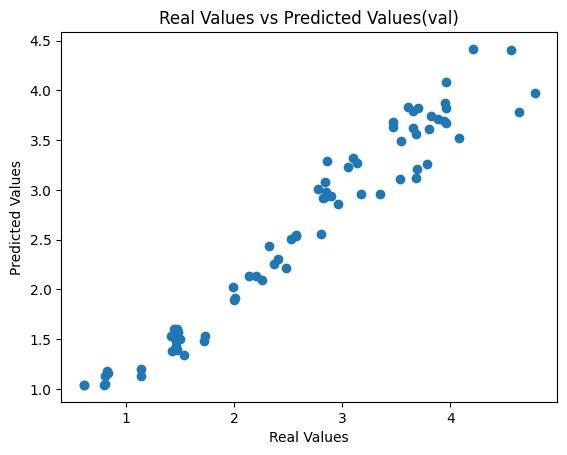

Val loss 0.06341012036427855
val acc 0.8
Epoch 10/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/md2_8.jpg
/content/drive/MyDrive/olive/segmented/md7_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/md3_2.jpg
/content/drive/MyDrive/olive/segmented/im11_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/olive/segmented/md4_4_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_6.jpg
/content/drive/MyDrive/oliv

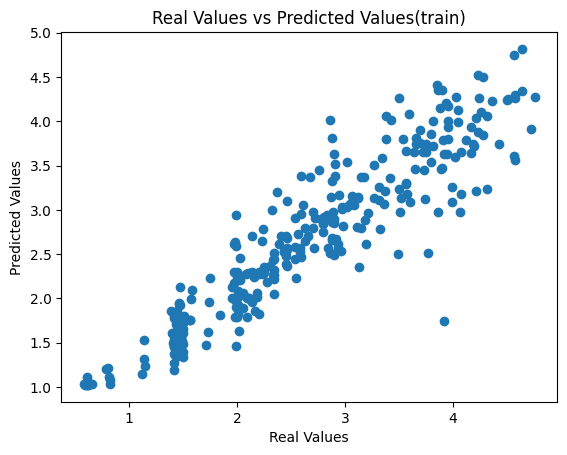

Train loss 0.14981181995244697
train acc 0.55
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_2.jpg
/content/drive/MyDrive/olive/segmented/md4_5_zoom_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/md4_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_1

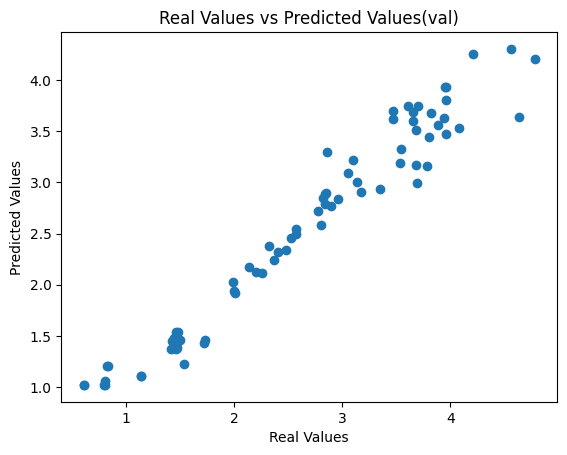

Val loss 0.06841021049767733
val acc 0.7125
Epoch 11/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_10.jpg
/content/drive/MyDrive/olive/segmented/md2_6.jpg
/content/drive/MyDrive/olive/segmented/im12_2_translation_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_121059_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_1.jpg
/content/drive/MyDrive/olive/segmented/md2_1_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_6.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_3.jpg
/content/drive/MyDrive/olive/segmented/im6_2.jpg
/content/drive/MyDrive/olive/segmented/md7_3.jpg
/content/drive/MyDrive/olive/segmented/im10.jpg
/content/drive/MyDrive/olive/segmented/im12_3.

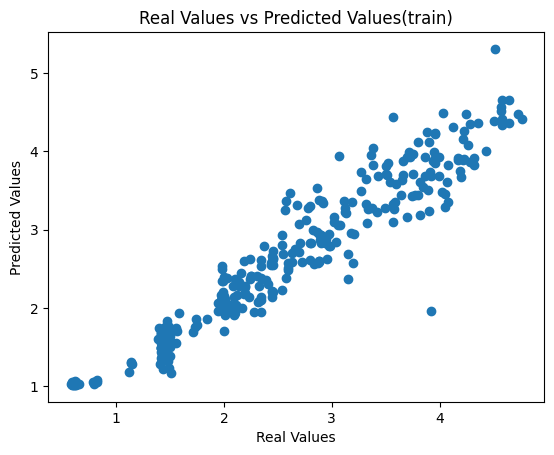

Train loss 0.09637765266234055
train acc 0.6
/content/drive/MyDrive/olive/segmented/md4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_2.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849_3.jpg
/content/drive/MyDri

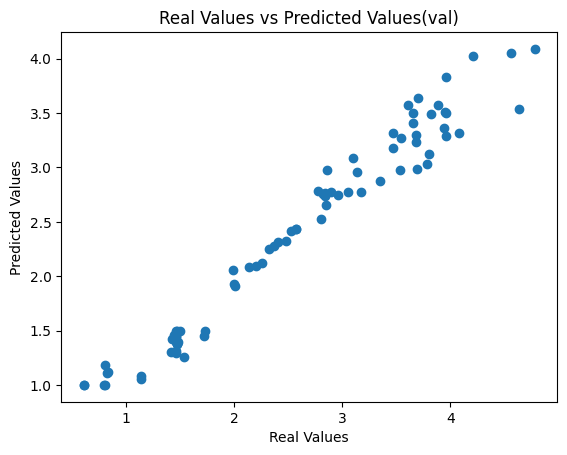

Val loss 0.10322660915553569
val acc 0.6375
Epoch 12/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im14_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_133501_1.jpg
/content/drive/MyDrive/olive/segmented/im1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_flip_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_4_8.jpg
/content/drive/MyDrive/olive/segmented/md4_4_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/im4_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633.jpg
/content/drive/MyDrive/olive/segmented/im1_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_2.jpg
/content/drive/MyDrive/olive/segmented/

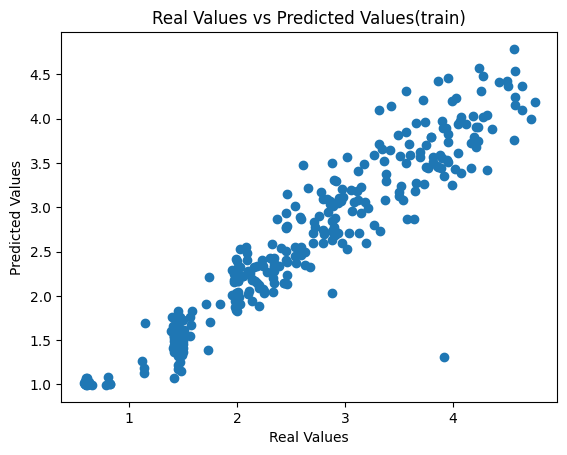

Train loss 0.11554586009588093
train acc 0.578125
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im9_4.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/O_130123.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/im3_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im2_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4.jpg
/content/drive/MyDrive/olive/segmented/im5_3.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_1

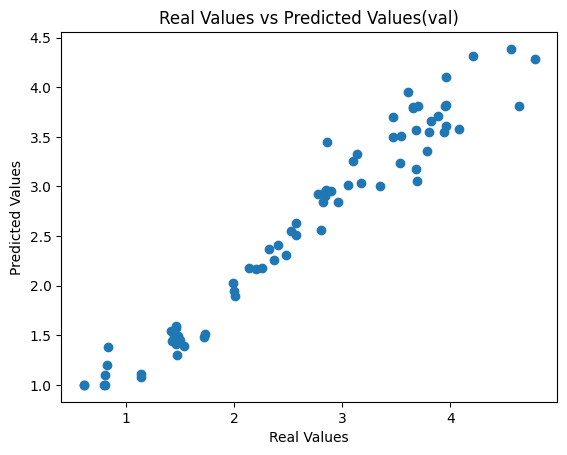

Val loss 0.058785658329725266
val acc 0.7875
Epoch 13/60
----------
/content/drive/MyDrive/olive/segmented/im13_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_130903_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im11_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_085405_1.jpg
/content/drive/MyDrive/olive/segmented/md2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im8_1.jpg
/content/drive/MyDrive/olive/segmented/im5_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_084643_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_202

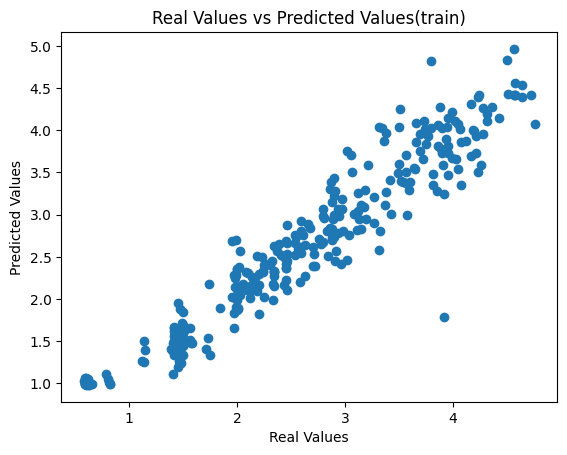

Train loss 0.09483261476270854
train acc 0.646875
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/im5_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_080515_2.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_1.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/md1_4_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_125942

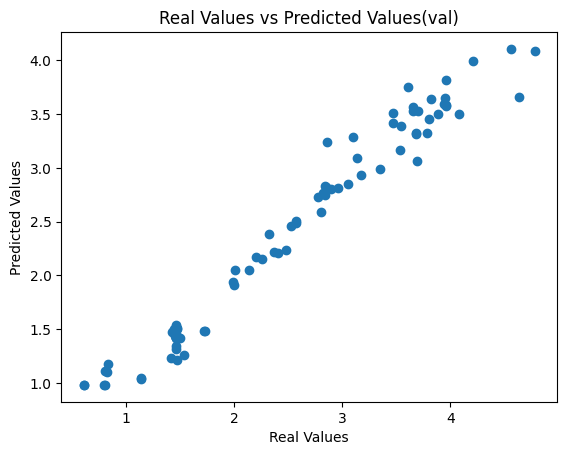

Val loss 0.0702455461025238
val acc 0.6875
Epoch 14/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003_1.jpg
/content/drive/MyDrive/olive/segmented/md1_5.jpg
/content/drive/MyDrive/olive/segmented/im12_2_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_1.jpg
/content/drive/MyDrive/olive/segmented/im7_2_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547.jpg
/content/drive/MyDrive/olive/segmented/im7.jpg
/content/drive/MyDrive/olive/segmented/im5_4.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_9.jpg
/content/drive/MyDrive/olive/segmented/md1_8.jpg
/content/drive/MyDrive/olive/segmented/md4_5_7.jpg
/content/drive/MyDrive/olive/segmented/im8.jpg
/content/drive/MyDrive/olive/segmented/im4_1.jpg
/content/drive/MyDrive/olive/segmented/md3_3.jpg
/content/drive/MyDrive/olive/segmented/md4_4_fl

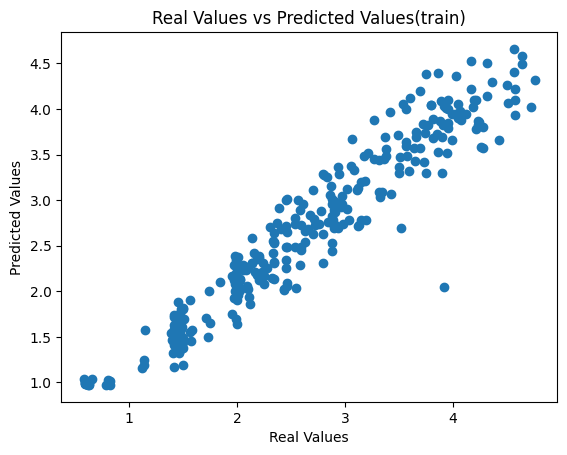

Train loss 0.08368931580334901
train acc 0.640625
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_141849.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/im13.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/

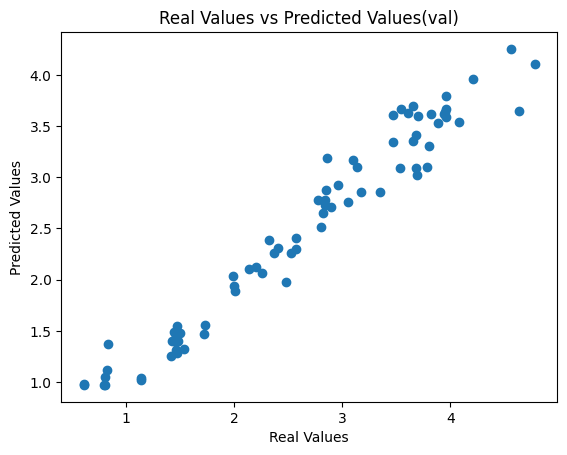

Val loss 0.08364251870661973
val acc 0.6375
Epoch 15/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_140547_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145.jpg
/content/drive/MyDrive/olive/segmented/O_125721_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_082659_5.jpg
/content/drive/MyDrive/olive/segmented/im9_2.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_rotation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_102305.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075520_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_rotation_10.jpg
/content/drive/MyDrive/olive/segmented/im4.jpg
/content/drive/

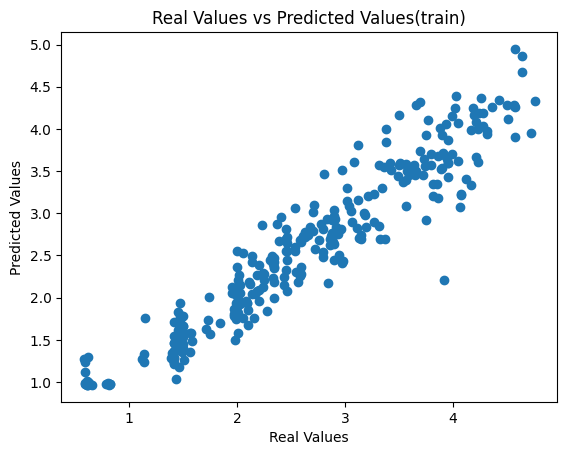

Train loss 0.10279122437350452
train acc 0.628125
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_10.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092845_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083350_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_1.jpg
/content/drive/MyDrive/olive/segmented/im7_5.jpg
/content/drive/MyDrive/olive/segmented/im2_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_7.jpg
/content/drive/MyDrive/olive/segmented/im14_1.jpg
/content/drive/MyDr

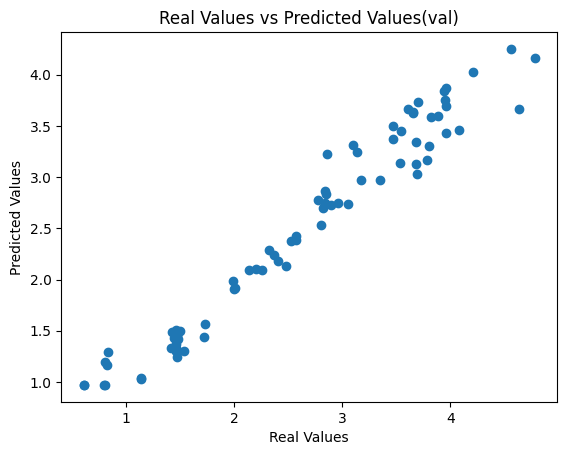

Val loss 0.07665368318557739
val acc 0.7
Epoch 16/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044.jpg
/content/drive/MyDrive/olive/segmented/im3_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_081229.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9_translation_9.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_6.jpg
/content/drive/MyDrive/olive/segmented/im12_2_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_075921_3.jpg
/content/drive/MyDrive/olive/segmented/im14_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427_3.jpg
/content/drive/MyDrive/olive/segmented/md2_5.jpg
/content/drive/MyDrive/olive/segmented/im14_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_8.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094943_5.jpg
/content/drive/MyDrive/olive/segmented/md4_4_transla

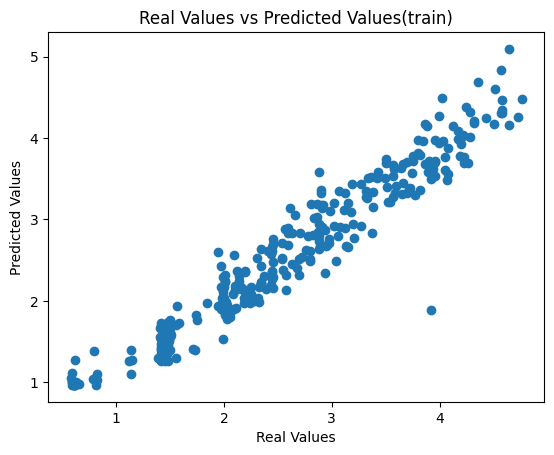

Train loss 0.07712995640467853
train acc 0.634375
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_115152_4.jpg
/content/drive/MyDrive/olive/segmented/md1_9.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_092044_1.jpg
/content/drive/MyDrive/olive/segmented/im6_4.jpg
/content/drive/MyDrive/olive/segmented/im10_2.jpg
/content/drive/MyDrive/olive/segmented/md4_4_translation_6.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_083105_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_zoom_8.jpg
/content/drive/MyDrive/olive/segmented/im14_5_flip_9.jpg
/content

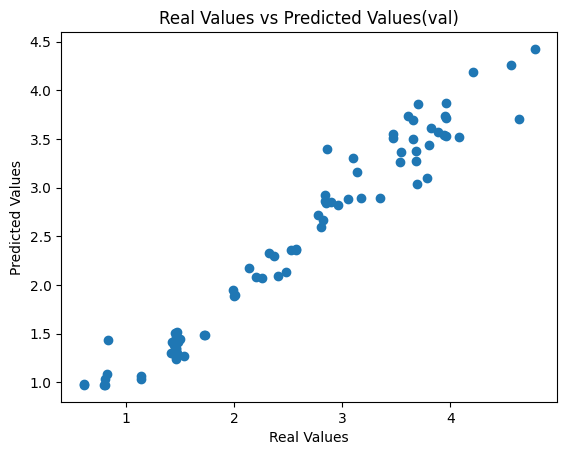

Val loss 0.07237145435065032
val acc 0.7125
Epoch 17/60
----------
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_103146_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_1_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_rotation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123517_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074427.jpg
/content/drive/MyDrive/olive/segmented/O_131625_1.jpg
/content/drive/MyDrive/olive/segmented/md2_3.jpg
/content/drive/MyDrive/olive/segmented/im12_2_8_zoom_6.jpg
/content/drive/MyDrive/olive/segmented/md8_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920.jpg
/content/drive/MyDrive/olive/segmented/im8_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_10_translation_7.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_8.jpg
/content/drive/MyDrive/oli

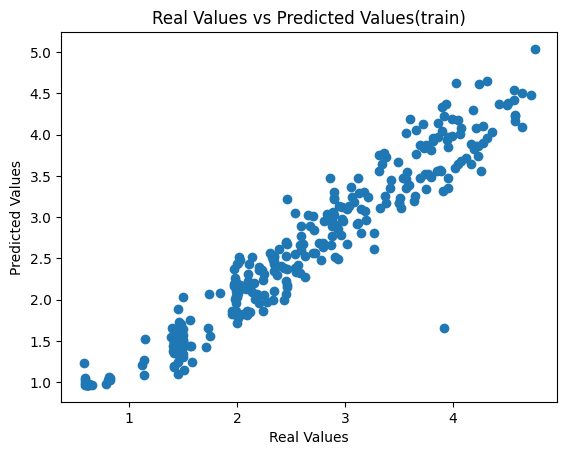

Train loss 0.0867275406839326
train acc 0.6375
/content/drive/MyDrive/olive/segmented/IMG_20220116_095920_5.jpg
/content/drive/MyDrive/olive/segmented/md8_5.jpg
/content/drive/MyDrive/olive/segmented/im14_5_translation_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_094149_2.jpg
/content/drive/MyDrive/olive/segmented/im3.jpg
/content/drive/MyDrive/olive/segmented/md1_7.jpg
/content/drive/MyDrive/olive/segmented/im11_3.jpg
/content/drive/MyDrive/olive/segmented/O_130123_4.jpg
/content/drive/MyDrive/olive/segmented/im12.jpg
/content/drive/MyDrive/olive/segmented/im11.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_074354_1.jpg
/content/drive/MyDrive/olive/segmented/im4_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_093428_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_132145_1.jpg
/content/drive/MyDrive/olive/segmented/im13_2.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_135633_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_13

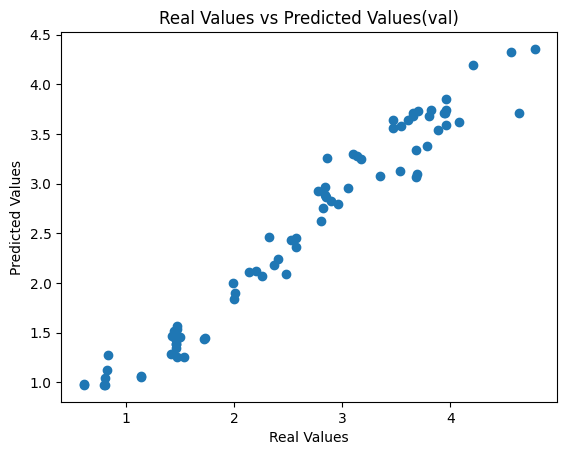

Val loss 0.0599821250885725
val acc 0.75
Epoch 18/60
----------
/content/drive/MyDrive/olive/segmented/im13_5.jpg
/content/drive/MyDrive/olive/segmented/im10_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_4.jpg
/content/drive/MyDrive/olive/segmented/md4_5_flip_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_091216_3.jpg
/content/drive/MyDrive/olive/segmented/md2_2_10.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_101502_4.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_091003_5.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_142748_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220116_090204_1.jpg
/content/drive/MyDrive/olive/segmented/IMG_20210603_092104_3.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_123400_7.jpg
/content/drive/MyDrive/olive/segmented/md4_5_9.jpg
/content/drive/MyDrive/olive/segmented/IMG_20220223_113845_10.jpg
/content/drive/MyDrive/olive/segmented/O_124141_3.jpg
/content/drive/MyDrive/olive/segmente

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model34, history34 = train_model(model34, device)


In [ ]:
import csv
model34 = models.resnet34(pretrained=True).to(device)
model34.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 1)
).to(device)


model34.load_state_dict(torch.load('/content/drive/MyDrive/olive/resnet34_3_07_checkpointx.pth'))

csv_file = "/content/drive/MyDrive/olive/Tree_height.csv"

for i in ["im1.jpg","im2.jpg","im3.jpg","im4.jpg","im5.jpg","im6.jpg","im7.jpg"]:
  print("**********************************",i)
  image = cv2.imread(i)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  input_tensor = transform(image)
  input_batch = input_tensor.unsqueeze(0).cuda()  # Add a batch dimension and move to GPU
  model34 = model34.cuda()  # Move the model to GPU

  with torch.no_grad():
      output = model34(input_batch)

  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  print("estimated value=",output.tolist()[0][0])
  with open(csv_file, "r") as file:
    reader = csv.DictReader(file)

    rows_with_value = []  # To store the rows with the value
    row_number = 0  # To track the current row number

    # Iterate over each row in the CSV file
    for row in reader:
        row_number += 1

        # Check if the value in the specified column matches the value to check
        if row["filename"] == i:
            rows_with_value.append((row_number, row))

    if rows_with_value:
        print("Value found in the following rows:")
        for row_number, row in rows_with_value:
            print("Row:", row_number)
            print("Data:", row)
            print("residual=",abs(float(row["height"])-output.tolist()[0][0]))
            print("\n")
            print("***********************************")
            print("\n")
    else:
        print("Value not found in the CSV file.")